In [14]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import math
import os.path
from os import path
from scipy.signal import butter, filtfilt, lfilter
from scipy import fftpack
import warnings
import seaborn as sns
from tqdm import tqdm 

In [47]:
user_id = 'User05'
#raw_data_dir_path = os.path.join('../data/parsed_data', user_id)
parsed_data_dir_path = os.path.join('../data/parsed_data/', user_id)
figs_dir_path = os.path.join('./figs/', user_id)

# read data from csv file
all_data = pd.read_csv(os.path.join(parsed_data_dir_path, 'all_data.csv'))
all_gesture_name = all_data['Gesture'].unique()
print(all_gesture_name)

all_data['ang_x'] = all_data['ang_x'].apply(lambda x: np.sin(x * np.pi / 180))
all_data['ang_y'] = all_data['ang_y'].apply(lambda x: np.sin(x * np.pi / 180))
all_data['ang_z'] = all_data['ang_z'].apply(lambda x: np.sin(x * np.pi / 180))

# all_data['ang_x_v'] = all_data['ang_x'].diff()
# all_data['ang_y_v'] = all_data['ang_y'].diff()
# all_data['ang_z_v'] = all_data['ang_z'].diff()

# all_data['ang_x_a'] = all_data['ang_x_v'].diff()
# all_data['ang_y_a'] = all_data['ang_y_v'].diff()
# all_data['ang_z_a'] = all_data['ang_z_v'].diff()

foots = ['rightfoot', 'leftfoot', 'bothfoot']
directions = ['RecordingForth', 'RecordingBack']
trackers = ['FootL', 'FootR']

['NormalWalking' 'TapWithHeel' 'TapWithFootRotatedInwards' 'LiftInFront'
 'ToeTapBehind' 'TapInFrontOfTheOtherFoot' 'TapWithFootRotatedOutwards'
 'ToeTapInFront' 'TapInward' 'DraggingBehind' 'KickInward' 'TapOuward'
 'KickForward' 'BigStep' 'MidairRotationOutwards' 'DraggingInFront'
 'Click' 'BendingBehind' 'Delay' 'SmallStep' 'MidairRotationInwards'
 'Rush' 'KickOutward']


In [16]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    # print('b: ', b, 'a: ', a)
    y = lfilter(b, a, data)
    return y

In [39]:
def get_head_data(data, gesture_name, foot, direction):
    local_gesture_data = data[(data['Gesture'] == gesture_name)
                              & (data['TrackerName'] == "Head") &
                              (data['Foot'] == foot) &
                              (data['Direction'] == direction)]

    # print('gesture_data shape: ', local_gesture_data.shape)

    checkpoint_list = local_gesture_data[local_gesture_data['Type'] == 'E']['Checkpoint'].tolist()
    local_gesture_data = local_gesture_data.drop_duplicates(subset=["Gesture", "Foot", "Direction", "Type", 'Checkpoint'], keep="last")
    # checked_checkpoint_list = []
    # for checkpoint in checkpoint_list:
    #     if checkpoint not in checked_checkpoint_list:
    #         if checkpoint_list.count(checkpoint) > 1:

    #             if type(checkpoint) == float:
    #                 candidates = local_gesture_data[
    #                     (local_gesture_data['Checkpoint'].isnull())
    #                     & (local_gesture_data['Type'] == 'E') &
    #                     (local_gesture_data['TrackerName'].isnull())]
    #             else:
    #                 candidates = local_gesture_data[
    #                     (local_gesture_data['Checkpoint'] == checkpoint)
    #                     & (local_gesture_data['Type'] == 'E') &
    #                     (local_gesture_data['TrackerName'].isnull())]

    #             # print(candidates['Time'])
    #             if candidates.size > 0:
    #                 start_time = candidates['Time'].iloc[0]
    #                 end_time = candidates['Time'].iloc[-1]
    #                 #print('checkpoint: ', checkpoint, 'start_time: ', start_time, 'end_time: ', end_time)

    #                 if type(checkpoint) == float:
    #                     local_gesture_data = local_gesture_data.drop(local_gesture_data[
    #                                                                      (local_gesture_data['Checkpoint'].isnull())
    #                                                                      & (local_gesture_data['Time'] >= start_time) &
    #                                                                      (local_gesture_data['Time'] < end_time)].index)
    #                 else:
    #                     local_gesture_data = local_gesture_data.drop(local_gesture_data[
    #                                                                      (local_gesture_data['Checkpoint'] == checkpoint)
    #                                                                      & (local_gesture_data['Time'] >= start_time) &
    #                                                                      (local_gesture_data['Time'] < end_time)].index)

    #                 # print('gesture_data shape: ', local_gesture_data.shape, 'gesture row sample ', local_gesture_data.iloc[0])
    #                 # update
    #                 checked_checkpoint_list.append(checkpoint)
    #                 # print("checked", checked_checkpoint_list)

    return local_gesture_data

In [18]:
def find_valleys(data, threshold):
    valleys = []
    data = np.array(data)

    for i in range(1, len(data) - 1):
        if data[i] < data[i - 1] and data[i] < data[i + 1] and data[i] < threshold:
            valleys.append(i)

    return valleys


def cut_step_data(tracker_data, gestureName, tracker_name, foot, direction):
    fs = 100
    order = 5

    # print('tracker_data shape: ', tracker_data.shape)

    tracker_data = tracker_data.copy()
    # tracker_data['pos_z_a'][2:] = butter_lowpass_filter(tracker_data['pos_z_a'][2:], 2, fs, order)

    # find the valleys
    # lowest_thresh = -0.5 / 100000

    # find the threshold
    # minimal = mean of the two lowest minima of the data
    minima = (np.diff(np.sign(np.diff(tracker_data['pos_z_a'][2:]))) > 0).nonzero()[0] + 1
    lowest_two_minima = tracker_data['pos_z_a'][2:].iloc[minima].nsmallest(5)
    minimal = lowest_two_minima.mean()


    average = tracker_data['pos_z_a'][2:].mean()
    threshold = (minimal + average) / 2.2

    valleys = find_valleys(tracker_data['pos_z_a'][2:], threshold)
    # valleys = find_mshape_valleys(tracker_data['pos_z_a'][2:])

    # cut the step data from the valleys
    all_steps = []
    for i in range(len(valleys) - 1):
        step = [valleys[i], valleys[i + 1]]
        all_steps.append(step)

    # print('steps amount: ', len(all_steps))
    # return the list of tracker data in each step

    all_steps_data = []
    for step in all_steps:
        step_data = tracker_data[step[0]:step[1]]
        all_steps_data.append(step_data)

    return all_steps_data

NormalWalking rightfoot RecordingForth (0, 13)
NormalWalking leftfoot RecordingForth (0, 13)
NormalWalking bothfoot RecordingForth (1901, 13)


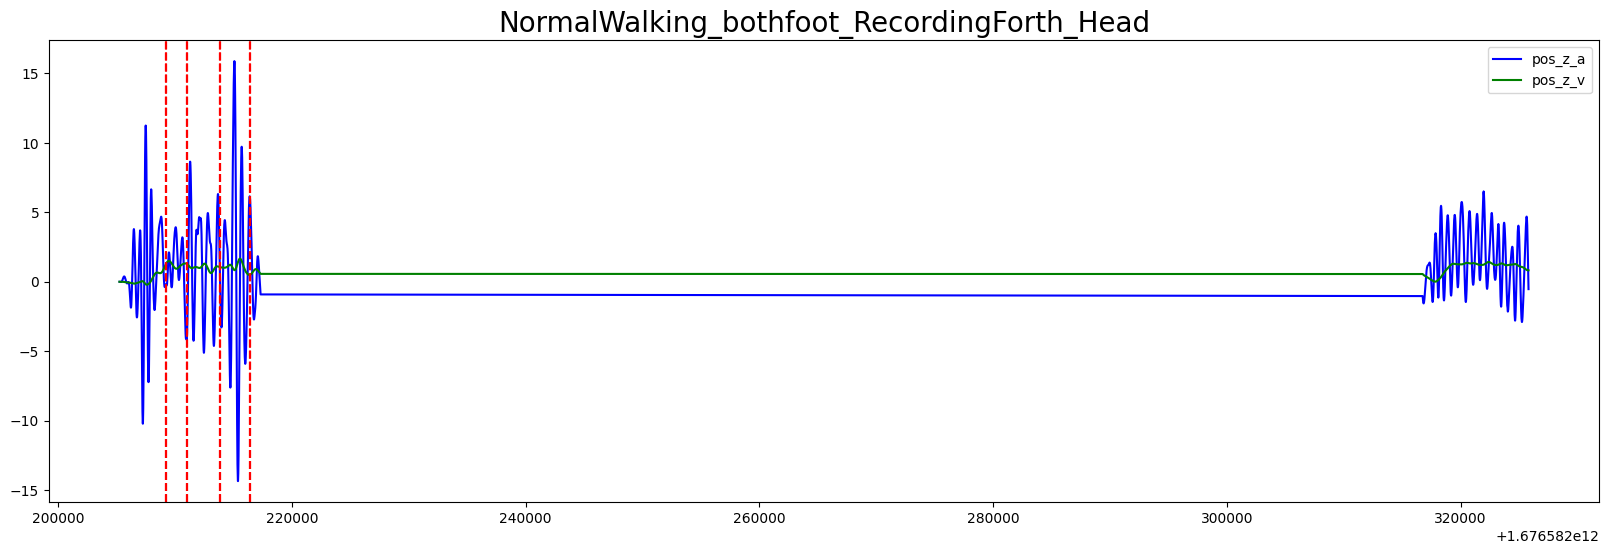

In [48]:
# for ploting the data with stride segmentation
for gesture in all_gesture_name[0:1]:
    if str(gesture) == 'nan':
        continue

    for foot in foots:
        for direction in directions[:1]:
            gesture_data = get_head_data(all_data, gesture, foot, direction)
            print(gesture, foot, direction, gesture_data.shape)
            

            if gesture_data.shape[0] == 0:
                continue

            # get the tracker data
            for tracker_name in ["Head"]:
            # tracker_name = 'Head'
                tracker_data = gesture_data[gesture_data['TrackerName'] == tracker_name]

                # if direction == 'RecordingBack', reverse pos_z, pos_x
                if direction == 'RecordingBack':
                    tracker_data['pos_z'] = -tracker_data['pos_z']
                    tracker_data['pos_x'] = -tracker_data['pos_x']


                for attr in ['pos_z']:
                    warnings.simplefilter("ignore")
                    tracker_data[attr + '_v'] = tracker_data[attr].diff() / tracker_data['Time'].diff()
                    tracker_data[attr + '_a'] = tracker_data[attr + '_v'].diff() / tracker_data['Time'].diff()

                    tracker_data[attr + '_v'][1:] = butter_lowpass_filter(tracker_data[attr + '_v'][1:], 1, 100, 5)
                    tracker_data[attr + '_a'][2:] = butter_lowpass_filter(tracker_data[attr + '_a'][2:], 2, 100, 5)

                # get the step data
                warnings.simplefilter("ignore")
                #all_steps_data = cut_step_data(tracker_data, gesture, tracker_name, foot, direction)

                # plot the all data in time series
                fig, ax = plt.subplots(1, 1, figsize=(20, 6))
                # title = direction, foot, gesture, tracker_name
                ax.set_title(gesture + '_' + foot + '_' + direction + '_' + tracker_name, fontsize=20)

                # plot pos_z_a, pos_y
                ax.plot(tracker_data['Time'], tracker_data['pos_z_a'] * 1000000, color='blue', label='pos_z_a')
                # ax.plot(tracker_data['Time'], tracker_data['pos_y'] , color='red', label='pos_y')
                ax.plot(tracker_data['Time'], tracker_data['pos_z_v'] * 1000, color='green', label='pos_z_v')
                # plot pos_z
                # ax.plot(tracker_data['Time'], tracker_data['pos_z'], color='black', label='pos_z')
                
                # plot pos_z_v, but with another tracker
                # anoteher_tracker_name = 'FootL' if tracker_name == 'FootR' else 'FootR'
                # other_tracker_data = gesture_data[gesture_data['TrackerName'] == anoteher_tracker_name]
                # other_tracker_data['pos_z'] = -other_tracker_data['pos_z'] if direction == 'RecordingBack' else other_tracker_data['pos_z']
                # other_tracker_data['pos_z_v'] = other_tracker_data['pos_z'].diff() / other_tracker_data['Time'].diff()
                # other_tracker_data['pos_z_v'][1:] = butter_lowpass_filter(other_tracker_data['pos_z_v'][1:], 1, 100, 5)
                # ax.plot(other_tracker_data['Time'], other_tracker_data['pos_z_v'] * 100, color='purple', label='pos_z_v (other)')

                ax.legend()

                checkpoints = gesture_data['Checkpoint'].unique()
                # print(checkpoints)
                for checkpoint in checkpoints[1:]:
                    checkpoint_data = gesture_data[gesture_data['Checkpoint'] == checkpoint]
                    ax.axvline(checkpoint_data['Time'].iloc[0], color='r', linestyle='--')
                    ax.axvline(checkpoint_data['Time'].iloc[0], color='r', linestyle='--')
                    ax.axvline(checkpoint_data['Time'].iloc[0], color='r', linestyle='--')

                # annotate the by steps
                # for step_count, step_data in enumerate(all_steps_data):
                #     ax.axvline(x=step_data['Time'].iloc[0], color='black', linestyle='--')
                #     ax.axvline(x=step_data['Time'].iloc[-1], color='black', linestyle='--')
                #     # ax.annotate('duration: ' + str(step_data['Time'].iloc[-1] - step_data['Time'].iloc[0]), xy=(step_data['Time'].iloc[0], 0), xytext=(step_data['Time'].iloc[0], 0), color='black')

                plt.show()

In [44]:
tracker_data["pos_z_v"]

64543             NaN
64549    1.973450e-11
64555    2.127978e-10
64561    1.147135e-09
64567    4.191049e-09
             ...     
70909    9.121741e-04
70915    9.124586e-04
70921    9.124155e-04
70927    9.120426e-04
70933    9.113388e-04
Name: pos_z_v, Length: 1065, dtype: float64